# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import joblib

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Load Data

In [2]:
# Update path as per your local system
DATA_PATH = "../data/raw/udemy_output_All_Finance__Accounting_p1_p626.csv"

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()


Shape: (13608, 20)


,id,title,url,is_paid,num_subscribers,avg_rating,avg_rating_recent,rating,num_reviews,is_wishlisted,num_published_lectures,num_published_practice_tests,created,published_time,discount_price__amount,discount_price__currency,discount_price__price_string,price_detail__amount,price_detail__currency,price_detail__price_string
0,762616,The Complete SQL Bootcamp 2020: Go from Zero t...,/course/the-complete-sql-bootcamp/,True,295509,4.66019,4.67874,4.67874,78006,False,84,0,2016-02-14T22:57:48Z,2016-04-06T05:16:11Z,455.0,INR,₹455,8640.0,INR,"₹8,640"
1,937678,Tableau 2020 A-Z: Hands-On Tableau Training fo...,/course/tableau10/,True,209070,4.58956,4.60015,4.60015,54581,False,78,0,2016-08-22T12:10:18Z,2016-08-23T16:59:49Z,455.0,INR,₹455,8640.0,INR,"₹8,640"
2,1361790,PMP Exam Prep Seminar - PMBOK Guide 6,/course/pmp-pmbok6-35-pdus/,True,155282,4.59491,4.59326,4.59326,52653,False,292,2,2017-09-26T16:32:48Z,2017-11-14T23:58:14Z,455.0,INR,₹455,8640.0,INR,"₹8,640"
3,648826,The Complete Financial Analyst Course 2020,/course/the-complete-financial-analyst-course/,True,245860,4.54407,4.53772,4.53772,46447,False,338,0,2015-10-23T13:34:35Z,2016-01-21T01:38:48Z,455.0,INR,₹455,8640.0,INR,"₹8,640"
4,637930,An Entire MBA in 1 Course:Award Winning Busine...,/course/an-entire-mba-in-1-courseaward-winning...,True,374836,4.47080,4.47173,4.47173,41630,False,83,0,2015-10-12T06:39:46Z,2016-01-11T21:39:33Z,455.0,INR,₹455,8640.0,INR,"₹8,640"


# Dataset Overview

In [3]:
df.info()
df.describe(include="all").T.head(20)
df.isnull().sum().sort_values(ascending=False).head(15)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13608 entries, 0 to 13607
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            13608 non-null  int64  
 1   title                         13608 non-null  object 
 2   url                           13608 non-null  object 
 3   is_paid                       13608 non-null  bool   
 4   num_subscribers               13608 non-null  int64  
 5   avg_rating                    13608 non-null  float64
 6   avg_rating_recent             13608 non-null  float64
 7   rating                        13608 non-null  float64
 8   num_reviews                   13608 non-null  int64  
 9   is_wishlisted                 13608 non-null  bool   
 10  num_published_lectures        13608 non-null  int64  
 11  num_published_practice_tests  13608 non-null  int64  
 12  created                       13608 non-null  object 
 13  p

discount_price__price_string    1403
discount_price__currency        1403
discount_price__amount          1403
price_detail__amount             497
price_detail__price_string       497
price_detail__currency           497
title                              0
id                                 0
is_paid                            0
url                                0
num_subscribers                    0
avg_rating                         0
num_published_practice_tests       0
num_published_lectures             0
is_wishlisted                      0
dtype: int64

# Clean Titles

In [4]:
def clean_title(t):
    t = str(t).lower().strip()
    t = re.sub(r"[^\w\s]", "", t)
    return t

df['title'] = df['title'].apply(clean_title)
df['title'].head(10)


0    the complete sql bootcamp 2020 go from zero to...
1    tableau 2020 az handson tableau training for d...
2                pmp exam prep seminar   pmbok guide 6
3           the complete financial analyst course 2020
4    an entire mba in 1 courseaward winning busines...
5    microsoft power bi  a complete introduction 20...
6    agile crash course agile project management ag...
7    beginner to pro in excel financial modeling an...
8    become a product manager  learn the skills  ge...
9        the business intelligence analyst course 2020
Name: title, dtype: object

# Categorize Titles

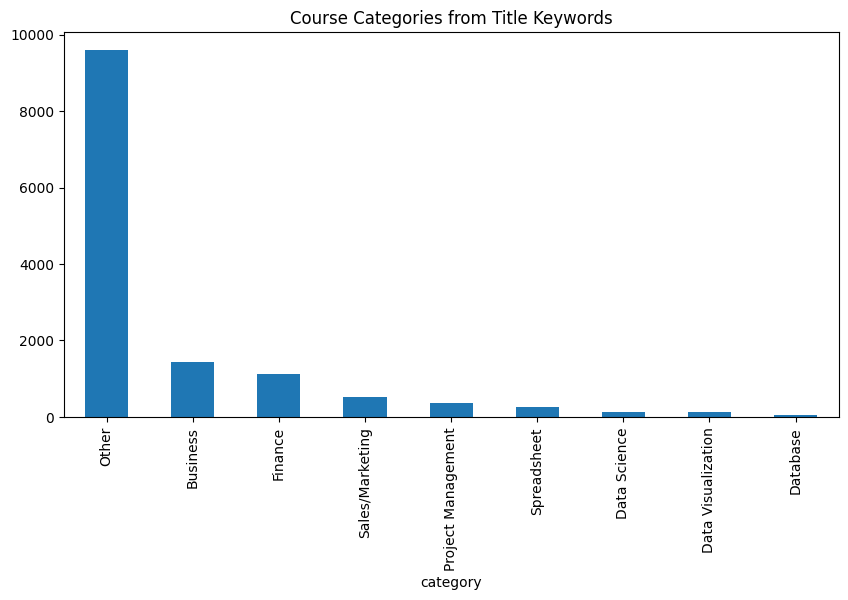

In [5]:
def categorize_title(title):
    tl = title.lower()
    if any(k in tl for k in ['sql','mysql','database']):
        return 'Database'
    if any(k in tl for k in ['tableau','power bi','data viz']):
        return 'Data Visualization'
    if 'excel' in tl or 'spreadsheet' in tl:
        return 'Spreadsheet'
    if any(kw in tl for kw in ['agile','scrum','pmp','project management']):
        return 'Project Management'
    if any(kw in tl for kw in ['financial','finance','accounting']):
        return 'Finance'
    if 'mba' in tl or 'business' in tl:
        return 'Business'
    if 'marketing' in tl or 'sale' in tl:
        return 'Sales/Marketing'
    if any(kw in tl for kw in ['data science','analytics','machine learning','ml']):
        return 'Data Science'
    return 'Other'

df['category'] = df['title'].apply(categorize_title)
df['category'].value_counts().plot(kind="bar", figsize=(10,5))
plt.title("Course Categories from Title Keywords")
plt.show()


# Feature Engineering

In [6]:
# Fill missing numerics with median
num_cols = ['rating','num_reviews','num_published_lectures','num_published_practice_tests',
            'discount_price__amount','price_detail__amount']
for col in num_cols:
    if col in df.columns:
        df[col].fillna(df[col].median(), inplace=True)

# Discount percentage
df['Discount_Percentage'] = np.where(
    df['price_detail__amount'] > 0,
    (df['price_detail__amount'] - df['discount_price__amount'])/df['price_detail__amount']*100,
    0
)

# Title features
df['title_len'] = df['title'].str.len()
df['title_word_count'] = df['title'].str.split().str.len()

df[['title','category','rating','num_reviews','Discount_Percentage','title_len']].head(10)


C:\Users\Gaurav Sahoo\AppData\Local\Temp\ipykernel_21500\4275716397.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\Gaurav Sahoo\AppData\Local\Temp\ipykernel_21500\4275716397.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a co

,title,category,rating,num_reviews,Discount_Percentage,title_len
0,the complete sql bootcamp 2020 go from zero to...,Database,4.67874,78006,94.733796,51
1,tableau 2020 az handson tableau training for d...,Data Visualization,4.60015,54581,94.733796,57
2,pmp exam prep seminar pmbok guide 6,Project Management,4.59326,52653,94.733796,37
3,the complete financial analyst course 2020,Finance,4.53772,46447,94.733796,42
4,an entire mba in 1 courseaward winning busines...,Business,4.47173,41630,94.733796,59
5,microsoft power bi a complete introduction 20...,Data Visualization,4.57676,38093,94.733796,56
6,agile crash course agile project management ag...,Project Management,4.29118,30470,94.733796,58
7,beginner to pro in excel financial modeling an...,Spreadsheet,4.53346,28665,94.733796,57
8,become a product manager learn the skills ge...,Other,4.50080,27408,94.733796,55
9,the business intelligence analyst course 2020,Business,4.49575,23906,94.733796,45


# Target & Features

In [7]:
TARGET = "num_subscribers"

num_features = ['rating','num_reviews','num_published_lectures',
                'num_published_practice_tests','discount_price__amount',
                'price_detail__amount','Discount_Percentage',
                'title_len','title_word_count']
cat_features = ['category']
text_feature = 'title'

X = df[num_features + cat_features + [text_feature]]
y = df[TARGET]
print("X shape:", X.shape, "y shape:", y.shape)


X shape: (13608, 11) y shape: (13608,)


# Train-Test Split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# Preprocessor & Model Pipeline

In [9]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

tfidf = TfidfVectorizer(max_features=1000)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features),
        ('text', tfidf, text_feature)
    ],
    sparse_threshold=0
)

model = RandomForestRegressor(n_estimators=200, random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])


In [15]:
df.to_csv("../data/processed/cleaned_data.csv", index=False)

# Train Model

In [11]:
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("R2 Score:", r2)


MAE: 2074.543217854519
RMSE: 6257.061811100835
R2 Score: 0.6726163646947286


# Plot Prediction

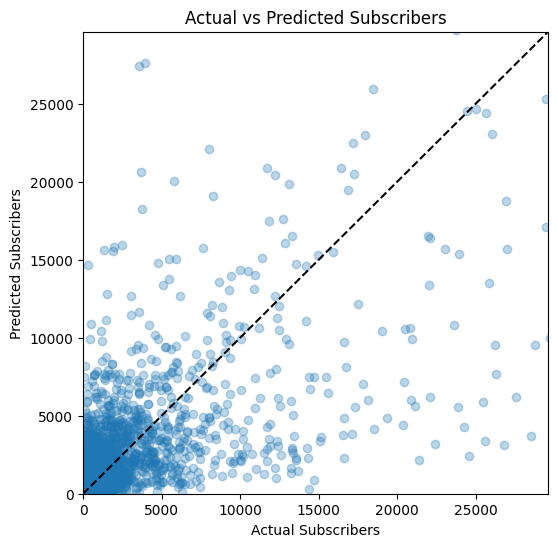

In [12]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual Subscribers")
plt.ylabel("Predicted Subscribers")
lims = [0, np.percentile(np.concatenate([y_test,y_pred]), 99)]
plt.xlim(lims); plt.ylim(lims)
plt.plot(lims, lims, '--', color='k')
plt.title("Actual vs Predicted Subscribers")
plt.show()


# Save Model

In [13]:
MODEL_PATH = "../models/udemy_subscribers_pipeline.joblib"
joblib.dump(pipeline, MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")


Model saved to ../models/udemy_subscribers_pipeline.joblib


# Load Model & Test

In [14]:
model_loaded = joblib.load(MODEL_PATH)

sample = pd.DataFrame([{
    'title': "the complete sql bootcamp",
    'rating': 4.5,
    'num_reviews': 200,
    'num_published_lectures': 50,
    'num_published_practice_tests': 0,
    'discount_price__amount': 10,
    'price_detail__amount': 100,
    'Discount_Percentage': 90,
    'title_len': len("the complete sql bootcamp"),
    'title_word_count': len("the complete sql bootcamp".split()),
    'category': "Database"
}])

print("Predicted Subscribers:", int(model_loaded.predict(sample)[0]))


Predicted Subscribers: 8670
